##### Importações

In [14]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import chi2_contingency, fisher_exact

In [2]:
df = pd.read_csv("../data/transformed/transformed_finance_data.csv")

In [3]:
df.head()

,user_id,age,gender,education_level,employment_status,job_title,monthly_income_usd,monthly_expenses_usd,savings_usd,has_loan,...,record_is_month_end,net_income_usd,expense_ratio,emi_to_income_ratio,savings_rate_monthly,debt_to_income_ratio_filled,credit_bucket,loan_term_years,loan_active,financial_stress_score
0,U00001,56,Female,High School,Self-Employed,Salesperson,3531.69,1182.59,367655.03,No,...,0,2349.10,0.334851,0.000000,8.675144,0.00,Poor,0.0,0,0.111617
1,U00002,19,Female,Phd,Employed,Salesperson,3531.73,2367.99,260869.10,Yes,...,0,1163.74,0.670490,1.402570,6.155366,1.40,Poor,3.0,1,0.561497
2,U00003,20,Female,Master,Employed,Teacher,2799.49,1003.91,230921.21,No,...,0,1795.58,0.358605,0.000000,6.873907,0.00,Very Good,0.0,0,0.119535
3,U00004,25,Male,Phd,Employed,Manager,5894.88,4440.12,304815.51,Yes,...,0,1454.76,0.753216,0.835737,4.309043,0.84,Poor,2.0,1,0.532451
4,U00005,53,Female,Phd,Employed,Student,5128.93,4137.61,461509.48,No,...,0,991.32,0.806720,0.000000,7.498469,0.00,Poor,0.0,0,0.268907


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32424 entries, 0 to 32423
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   user_id                      32424 non-null  object 
 1   age                          32424 non-null  int64  
 2   gender                       32424 non-null  object 
 3   education_level              32424 non-null  object 
 4   employment_status            32424 non-null  object 
 5   job_title                    32424 non-null  object 
 6   monthly_income_usd           32424 non-null  float64
 7   monthly_expenses_usd         32424 non-null  float64
 8   savings_usd                  32424 non-null  float64
 9   has_loan                     32424 non-null  object 
 10  loan_type                    12995 non-null  object 
 11  loan_amount_usd              32424 non-null  float64
 12  loan_term_months             32424 non-null  int64  
 13  monthly_emi_usd 

##### Análise Estatística

In [7]:
def describe_plus(df, cmap="Blues", decimals=2):
    df_num = df.select_dtypes(include=[np.number])
    
    extra = pd.DataFrame({
        "median": df_num.median(),
        "iqr": df_num.quantile(0.75) - df_num.quantile(0.25),
        "cv": df_num.std() / df_num.mean(),
        "skew": df_num.skew(),
        "kurtosis": df_num.kurtosis(),
        "amplitude": df_num.max() - df_num.min(),
        "coef_var": df_num.apply(lambda x: stats.variation(x.dropna()))
    })
    summary = pd.concat([df_num.describe().T, extra], axis=1)
    
    return summary.style.background_gradient(cmap=cmap).format(f"{{:.{decimals}f}}")

In [ ]:
df_numeric = df.select_dtypes(include=[np.number])

In [6]:
print(f"Number of rows: {df.shape[0]}, Number of columns: {df.shape[1]}")

Number of rows: 32424, Number of columns: 35


In [8]:
describe_plus(df, cmap="plasma")

,count,mean,std,min,25%,50%,75%,max,median,iqr,cv,skew,kurtosis,amplitude,coef_var
age,32424.00,43.42,14.98,18.00,30.00,43.00,56.00,69.00,43.00,26.00,0.34,0.01,-1.20,51.00,0.34
monthly_income_usd,32424.00,4025.87,1910.62,500.00,2657.80,3997.74,5351.61,9392.33,3997.74,2693.81,0.47,0.16,-0.41,8892.33,0.47
monthly_expenses_usd,32424.00,2408.78,1355.71,150.01,1397.50,2219.57,3254.04,6038.85,2219.57,1856.54,0.56,0.59,-0.14,5888.84,0.56
savings_usd,32424.00,242491.11,187534.59,635.96,86291.55,201700.33,358966.22,767978.22,201700.33,272674.67,0.77,0.84,-0.01,767342.26,0.77
loan_amount_usd,32424.00,99856.55,151887.93,0.00,0.00,0.00,189499.07,473747.67,0.00,189499.07,1.52,1.24,0.05,473747.67,1.52
loan_term_months,32424.00,37.52,58.52,0.00,0.00,0.00,60.00,150.00,0.00,60.00,1.56,1.21,-0.33,150.00,1.56
monthly_emi_usd,32424.00,2071.62,3208.27,0.00,0.00,0.00,3574.57,8936.42,0.00,3574.57,1.55,1.27,0.00,8936.42,1.55
loan_interest_rate_pct,32424.00,6.62,9.47,0.00,0.00,0.00,13.14,30.00,0.00,13.14,1.43,1.10,-0.28,30.00,1.43
debt_to_income_ratio,32424.00,0.55,0.85,0.00,0.00,0.00,0.92,2.30,0.00,0.92,1.55,1.25,-0.10,2.30,1.55
credit_score,32424.00,575.26,159.02,300.00,437.00,575.00,714.00,850.00,575.00,277.00,0.28,-0.00,-1.20,550.00,0.28


In [20]:
sns.set_theme(style="dark")
plt.style.use("dark_background")

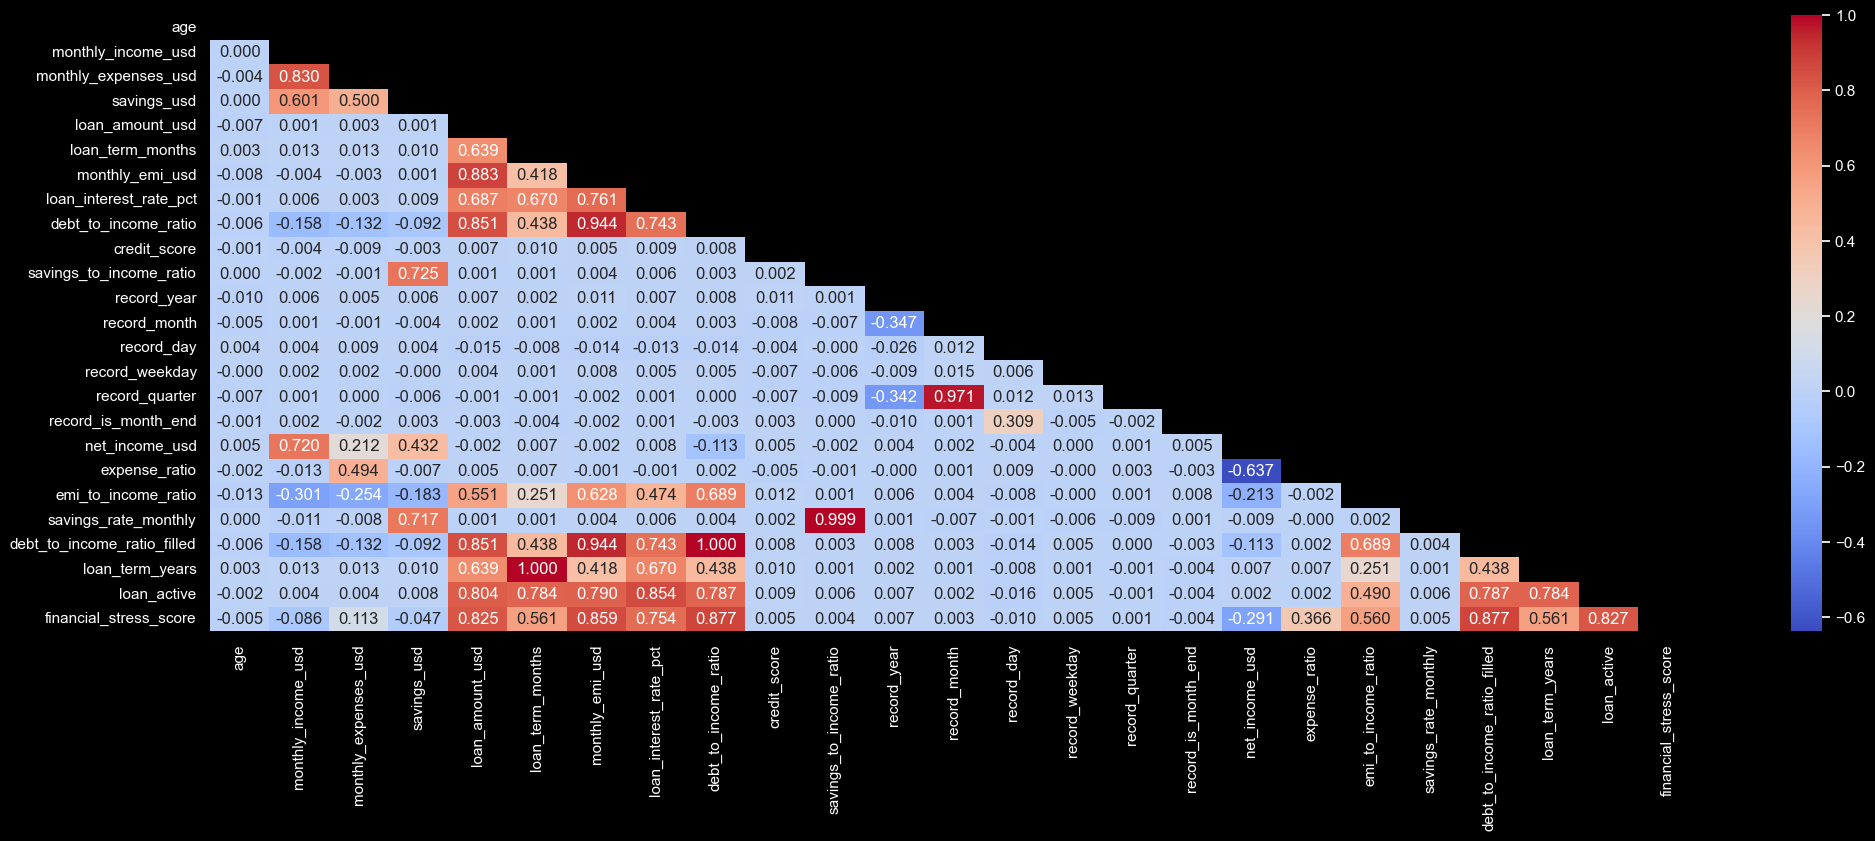

In [21]:
corr_matrix = df_numeric.corr(method="pearson")
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(24, 8))
sns.heatmap(corr_matrix, mask=mask, cmap="coolwarm", annot=True, fmt=".3f")
plt.show()

In [22]:
def normality_test_fluxogram(series, alpha=0.05):
    x = series.dropna()
    n = len(x)
    if n < 3:
        return {'Coluna': series.name, 'Teste': None, 'Estatística': None, 'p-valor': None,
                'Interpretação': 'Amostra muito pequena para teste de normalidade.'}
    
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    prop_outliers = ((x < lower_bound) | (x > upper_bound)).mean()

    muitos_outliers = prop_outliers > 0.01

    result = None
    if muitos_outliers:
        try:
            stat, pval = stats.lilliefors(x, dist='norm')
            teste = 'Lilliefors (KS ajustado)'
        except:
            result = stats.anderson(x, dist='norm')
            stat, pval = result.statistic, None
            teste = 'Anderson-Darling'
    else:
        if n < 5000:
            stat, pval = stats.shapiro(x)
            teste = 'Shapiro-Wilk'
        else:
            stat, pval = stats.normaltest(x)
            teste = 'DAgostino-Pearson'

    if pval is None: 
        crit_5pct = None
        for cv, sl in zip(result.critical_values, result.significance_level):
            if sl == 5:
                crit_5pct = cv
                break
        if crit_5pct is not None and stat < crit_5pct:
            interpret = 'Provavelmente normal'
        else:
            interpret = 'Provavelmente não normal'
        pval_str = 'N/A'
    else:
        pval_str = f'{pval:.4f}'
        interpret = 'Provavelmente normal' if pval > alpha else 'Provavelmente não normal'

    return {
        'Coluna': series.name,
        'Teste': teste,
        'Estatística': round(stat, 4),
        'p-valor': pval_str,
        'Interpretação': interpret
    }

In [23]:
def highlight(row):
    color = '#850505' if "normal" in row['Interpretação'].lower() else '#1d7d36'
    return ['background-color: {}'.format(color) if col == 'Interpretação' else '' for col in row.index]

In [24]:
resultados = []
for col in df.select_dtypes(include=[np.number]).columns:
    resultados.append(normality_test_fluxogram(df[col], alpha=0.05))

df_resultados = pd.DataFrame(resultados)
df_resultados.style.apply(highlight, axis=1)

,Coluna,Teste,Estatística,p-valor,Interpretação
0,age,DAgostino-Pearson,27787.032200,0.0000,Provavelmente não normal
1,monthly_income_usd,DAgostino-Pearson,519.418200,0.0000,Provavelmente não normal
2,monthly_expenses_usd,DAgostino-Pearson,1673.328800,0.0000,Provavelmente não normal
3,savings_usd,DAgostino-Pearson,2928.974300,0.0000,Provavelmente não normal
4,loan_amount_usd,DAgostino-Pearson,5255.336800,0.0000,Provavelmente não normal
5,loan_term_months,DAgostino-Pearson,5265.766500,0.0000,Provavelmente não normal
6,monthly_emi_usd,DAgostino-Pearson,5386.961700,0.0000,Provavelmente não normal
7,loan_interest_rate_pct,DAgostino-Pearson,4563.108200,0.0000,Provavelmente não normal
8,debt_to_income_ratio,DAgostino-Pearson,5299.559200,0.0000,Provavelmente não normal
9,credit_score,DAgostino-Pearson,29044.815600,0.0000,Provavelmente não normal


In [25]:
def cramers_v(tabela):
    chi2, _, _, _ = chi2_contingency(tabela)
    n = tabela.sum().sum()
    min_dim = min(tabela.shape) - 1
    return np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else np.nan

In [26]:
def analisar_relacoes_categoricas(df, alpha=0.05):
    resultados = []
    colunas_cat = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    for col1, col2 in combinations(colunas_cat, 2):
        tabela = pd.crosstab(df[col1], df[col2])
        
        if tabela.shape == (2, 2):
            estatistica, p_valor = fisher_exact(tabela)
            teste = "Fisher Exato"

        else:
            estatistica, p_valor, _, _ = chi2_contingency(tabela)
            teste = "Qui-quadrado"

        interpretacao = "Associadas" if p_valor <= alpha else "Independentes"
        
        cramer_v = cramers_v(tabela)
        
        resultados.append({
            "Coluna 1": col1,
            "Coluna 2": col2,
            "Teste": teste,
            "Estatística": estatistica,
            "p-valor": p_valor,
            "Cramér's V": cramer_v,
            "Interpretação": interpretacao
        })
    
    df_result = pd.DataFrame(resultados)
    df_result = df_result.sort_values(by="Cramér's V", ascending=False).reset_index(drop=True)
    
    styled = (
        df_result.style
        .bar(subset=["Cramér's V"], color="#ffb347")
        .map(lambda v: "background-color: #ff9999" if v == "Associadas" else "", subset=["Interpretação"])
        .format({
            "p-valor": "{:.4f}",
            "Estatística": "{:.3f}",
            "Cramér's V": "{:.3f}"
        })
        .set_caption("Relações entre Variáveis Categóricas")
        .set_table_styles([
            {"selector": "caption", "props": [("font-size", "16px"), ("font-weight", "bold")]}
        ])
    )

    
    return styled

In [27]:
resultados_cat = analisar_relacoes_categoricas(df, alpha=0.05)
resultados_cat

,Coluna 1,Coluna 2,Teste,Estatística,p-valor,Cramér's V,Interpretação
0,user_id,gender,Qui-quadrado,64848.000,0.4970,1.000,Independentes
1,user_id,education_level,Qui-quadrado,129696.000,0.4963,1.000,Independentes
2,user_id,employment_status,Qui-quadrado,97272.000,0.4967,1.000,Independentes
3,user_id,job_title,Qui-quadrado,259392.000,0.4952,1.000,Independentes
4,user_id,loan_type,Qui-quadrado,38985.000,0.4948,1.000,Independentes
5,user_id,region,Qui-quadrado,129696.000,0.4963,1.000,Independentes
6,user_id,record_date,Qui-quadrado,47339040.000,0.4403,1.000,Independentes
7,user_id,has_loan,Qui-quadrado,32424.000,0.4974,1.000,Independentes
8,user_id,credit_bucket,Qui-quadrado,129696.000,0.4963,1.000,Independentes
9,loan_type,record_date,Qui-quadrado,4352.620,0.6126,0.334,Independentes
